## Install and Import dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from textblob import TextBlob, Word
import seaborn as sns
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
import string
import transformers
import torch



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Akhila\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\Akhila\Desktop\lancs\LUMS\Careers\MachineLearning\TripAdvisor_Hotel_Review_Sentiment_Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
df = pd.read_csv('data/reviews.csv')
df.shape

(20491, 1)

## Data Analysis

In [3]:
df.head()

,Review
0,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...
3,"unique, great stay, wonderful time hotel monac..."
4,"great stay great stay, went seahawk game aweso..."


In [4]:
#Counting number of words each Review has
df['word_count'] = df['Review'].apply(lambda x: len(x.split()))

In [5]:
#Counting characters in each Review 
df['char_count'] = df['Review'].apply(lambda x: len(x))

In [6]:
#counting average word length in each review
def average_word_len(x):
    words = x.split()
    return sum(len(word) for word in words)/len(words)

df['average_word_length'] = df['Review'].apply(lambda x: average_word_len(x))

In [7]:
#counting stopwords in each Review
stop_words = stopwords.words("english")
df['stopword_count'] = df['Review'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))

In [8]:
#creating a stopword rate feature 
df['stopword_rate'] = df['stopword_count']/df['word_count']

In [9]:
df.describe()

,word_count,char_count,average_word_length,stopword_count,stopword_rate
count,20491.000000,20491.000000,20491.000000,20491.000000,20491.000000
mean,104.375824,724.896833,5.996976,3.572788,0.031342
std,100.656586,689.101024,0.441074,4.661568,0.025985
min,7.000000,44.000000,4.038462,0.000000,0.000000
25%,48.000000,339.000000,5.703704,1.000000,0.012658
50%,77.000000,537.000000,5.971831,2.000000,0.028169
75%,124.000000,859.000000,6.260870,5.000000,0.045455
max,1931.000000,13501.000000,8.666667,85.000000,0.245283


## Data Cleaning

In [10]:
#Normalise text: lowercase
df['lowercase'] = df['Review'].apply(lambda x : " ".join(word.lower() for word in x.split()))

In [11]:
#Normalise text: remove punctuation
import re #using regex
df['punctuation'] = df['lowercase'].apply(lambda x: re.sub('[^a-zA-Z\s]', " ",x )) # remove non alphabetic characters
df['punctuation'] = df['punctuation'].apply(lambda x: re.sub('\s+'," ", x )) # remove extra spaces


In [12]:
#remove single letter tokens and stopwords
stop_words = stopwords.words("english")
alphs = list(string.ascii_letters) # add single letters to stopwords
stop_words = stop_words+alphs
stop_words.remove('not') #remove 'not' from stopwords list

df['stopwords'] = df['punctuation'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

In [16]:
#lemmatize test
df['lemmatize'] = df['stopwords'].apply(lambda x: " ".join(Word(word).lemmatize('v') for word in x.split()))

In [24]:
df.drop(columns=['lowercase', 'punctuation'], inplace=True)

In [25]:
df.rename(columns={'lemmatize':'Review_Final'}, inplace=True)

In [27]:
df.head(2)

,Review,word_count,char_count,average_word_length,stopword_count,stopword_rate,stopwords,Review_Final
0,nice hotel expensive parking got good deal sta...,87,593,5.804598,6,0.068966,nice hotel expensive parking got good deal sta...,nice hotel expensive park get good deal stay h...
1,ok nothing special charge diamond member hilto...,250,1689,5.752000,12,0.048000,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...


In [28]:
#character count on final processed reviews and compare with character count on raw reviews.
df['char_count_processed'] = df['Review_Final'].apply(lambda x: len(x))

In [32]:
df.loc[0:5, ['char_count','char_count_processed']]


,char_count,char_count_processed
0,593,518
1,1689,1538
2,1427,1251
3,600,539
4,1281,1103
5,1002,900


Can notice that the character count has been reduced significantly after preprocessing reviews.

## Sentiment Analysis using Textblob

In [ ]:
df['polarity'] = df['Review_Final'].apply(lambda x: list(TextBlob(x).sentiment)[0])


In [38]:
df['polarity'].describe()



count    20491.000000
mean         0.278787
std          0.176166
min         -1.000000
25%          0.182500
50%          0.283693
75%          0.383951
max          1.000000
Name: polarity, dtype: float64

In [ ]:
# Define bins and labels for classification
#classify: -1 <= polarity < 0.1 := Negative | -0.1 <= polarity < 0.1 := Neutral | 0.1 <= polarity < 0.1 := Positive
bins = [-1, -0.1, 0.1, 1]
labels = ['negative', 'neutral', 'positive']

# Use pd.cut to classify polarity into categories
df['Sentiment_Score_Textblob'] = pd.cut(df['polarity'], bins=bins, labels=labels, include_lowest=True)

# Display the results
print(df[['Review_Final', 'polarity', 'Sentiment_Score_Textblob']])

                                            Review_Final  polarity sentiment
0      nice hotel expensive park get good deal stay h...  0.246244  positive
1      ok nothing special charge diamond member hilto...  0.185357  positive
2      nice room not experience hotel monaco seattle ...  0.336480  positive
3      unique great stay wonderful time hotel monaco ...  0.532870  positive
4      great stay great stay go seahawk game awesome ...  0.382143  positive
...                                                  ...       ...       ...
20486  best keep secret rd time stay charm not star c...  0.212638  positive
20487  great location price view hotel great quick pl...  0.463333  positive
20488  ok look nice modern outside desk staff particu...  0.193365  positive
20489  hotel theft ruin vacation hotel open sept gues...  0.148511  positive
20490  people talk ca believe excellent rat hotel yes...  0.132738  positive

[20491 rows x 3 columns]


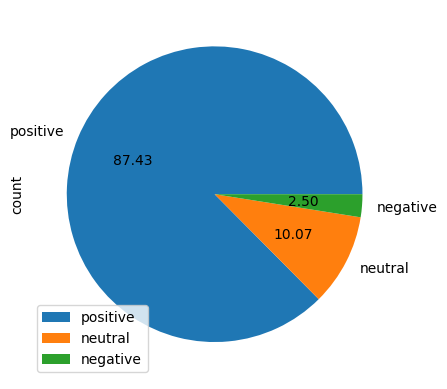

In [ ]:

# Visualize sentiment distribution
df['Sentiment_Score_Textblob'].value_counts().plot(kind="pie", autopct="%.2f")
plt.legend(loc="lower left")
plt.show()

## Analysis of Textblob results 

In [ ]:
analysis_df = df[['Review', 'polarity', 'Sentiment_Score_Textblob']]
analysis_df['polarity'].describe()

,Review,polarity,Sentiment_Score_Textblob
0,nice hotel expensive parking got good deal sta...,0.246244,positive
1,ok nothing special charge diamond member hilto...,0.185357,positive
2,nice rooms not 4* experience hotel monaco seat...,0.336480,positive
4,"great stay great stay, went seahawk game aweso...",0.382143,positive
5,love monaco staff husband stayed hotel crazy w...,0.292754,positive
6,"cozy stay rainy city, husband spent 7 nights m...",0.385179,positive
8,"hotel stayed hotel monaco cruise, rooms genero...",0.257341,positive
9,excellent stayed hotel monaco past w/e delight...,0.237637,positive
10,"poor value stayed monaco seattle july, nice ho...",0.260606,positive
11,nice value seattle stayed 4 nights late 2007. ...,0.304882,positive


In [ ]:
#Negative reviews analysis
#Analysis of positive reviews with scores below 0
analysis_df[df['polarity']<-0.1].head(10)
#all the reviews seem to be negative in this range of score.

,Review,polarity,Sentiment_Score_Textblob
42,warwick bad good reviews warwick shocks staff ...,-0.230000,negative
65,"hated inn terrible, room-service horrible staf...",-0.350000,negative
76,"stay clear, internet reservation friday rang h...",-0.121429,negative
77,single rooms like hospital rooms single rooms ...,-0.160565,negative
101,dump stayed weekend expected charming 1929 pro...,-0.408929,negative
141,"terrible experience awful night stay, planned ...",-0.406250,negative
160,cramped noisy overrated husband just stayed ho...,-0.161472,negative
174,upgrade outdated arrived given junior suite ma...,-0.279167,negative
181,worst hotel experience thinking booking room h...,-0.281513,negative
191,checked early wo n't stay room dirty checked f...,-0.135714,negative


In [ ]:
##Analysis of neutral reviews with scores -0.1 to 0.1
analysis_df[df['polarity'].between(-0.1, 0.1)].head(10)

#Majority of the reviews seem negative.

,Review,polarity,Sentiment_Score_Textblob
13,nice hotel not nice staff hotel lovely staff q...,-0.032500,neutral
15,horrible customer service hotel stay february ...,-0.000617,neutral
27,met expectations centrally located hotel block...,0.048864,neutral
40,"bad choice, booked hotel hot wire called immed...",0.060476,neutral
44,"austin powers decor familiar, hotel seattlewhe...",-0.043056,neutral
45,great location n't stay long needed place stay...,0.096893,neutral
54,"expensive, not biz travellers, simple fact hot...",0.024603,neutral
83,"holiday inn, 1st time seattle delayed annivers...",0.006593,neutral
88,worst hotel experience booked nonsmoking room ...,-0.089583,neutral
92,quaint not rundown son decided celebrate gradu...,0.031111,neutral


In [ ]:
#Analysis of positive reviews with scores 0.1 to 0.4
analysis_df[df['polarity'].between(0.1, 0.4)].head(10)

#review at index 1 with polarity 0.18 do not seem positive. Let's analyse reviews with scores between 0.1 and 0.2 for better clarity.


,Review,polarity,Sentiment_Score_Textblob
0,nice hotel expensive parking got good deal sta...,0.246244,positive
1,ok nothing special charge diamond member hilto...,0.185357,positive
2,nice rooms not 4* experience hotel monaco seat...,0.336480,positive
4,"great stay great stay, went seahawk game aweso...",0.382143,positive
5,love monaco staff husband stayed hotel crazy w...,0.292754,positive
6,"cozy stay rainy city, husband spent 7 nights m...",0.385179,positive
8,"hotel stayed hotel monaco cruise, rooms genero...",0.257341,positive
9,excellent stayed hotel monaco past w/e delight...,0.237637,positive
10,"poor value stayed monaco seattle july, nice ho...",0.260606,positive
11,nice value seattle stayed 4 nights late 2007. ...,0.304882,positive


In [ ]:
#Analysis of positive reviews with scores 0.1 to 0.4
analysis_df[df['polarity'].between(0.1, 0.2)].head(20)

# we have plenty reviews in this range that do not seem positive. Let's analyse them with scores between 0.2 and 0.3

,Review,polarity,Sentiment_Score_Textblob
1,ok nothing special charge diamond member hilto...,0.185357,positive
16,disappointed say anticipating stay hotel monac...,0.169330,positive
19,hmmmmm say really high hopes hotel monaco chos...,0.120000,positive
20,service service service spent week g-friend la...,0.187571,positive
31,great location expensive parking warwick heart...,0.189377,positive
32,"noise airconditioner-a standard, arranged stay...",0.127976,positive
33,good location poor cleanliness warwick hotel g...,0.126389,positive
38,"pretty good value visit seattle frequently, 1 ...",0.121429,positive
46,"pay read reviews booked knew getting, mind n't...",0.112500,positive
47,"not bad location unmatchable price range, simp...",0.195641,positive


In [ ]:
analysis_df[df['polarity'].between(0.2, 0.3)].head(20)
#Majority of the reviews seem to be positive. Let's analyse them with scores above 0.3.

,Review,polarity,Sentiment_Score_Textblob
0,nice hotel expensive parking got good deal sta...,0.246244,positive
5,love monaco staff husband stayed hotel crazy w...,0.292754,positive
8,"hotel stayed hotel monaco cruise, rooms genero...",0.257341,positive
9,excellent stayed hotel monaco past w/e delight...,0.237637,positive
10,"poor value stayed monaco seattle july, nice ho...",0.260606,positive
12,nice hotel good location hotel kimpton design ...,0.238418,positive
14,"great hotel night quick business trip, loved l...",0.282870,positive
17,fantastic stay monaco seattle hotel monaco hol...,0.261263,positive
24,great location need internally upgrade advanta...,0.259375,positive
25,"n't mind noise place great, read reviews noise...",0.220833,positive


In [ ]:
analysis_df[df['polarity']>0.3].head(20)
#all positive reviews

,Review,polarity,Sentiment_Score_Textblob
2,nice rooms not 4* experience hotel monaco seat...,0.336480,positive
3,"unique, great stay, wonderful time hotel monac...",0.532870,positive
4,"great stay great stay, went seahawk game aweso...",0.382143,positive
6,"cozy stay rainy city, husband spent 7 nights m...",0.385179,positive
7,"excellent staff, housekeeping quality hotel ch...",0.562963,positive
11,nice value seattle stayed 4 nights late 2007. ...,0.304882,positive
18,"good choice hotel recommended sister, great lo...",0.500000,positive
21,"excellent stay, delightful surprise stay monac...",0.559375,positive
22,good value downtown hotel monaco seattle great...,0.340833,positive
23,hotel monaco great location service hotel mona...,0.307222,positive


It gets tricky to identify threshold for neural reviews. For now, let's just go with classification of reviews into positive and negative. Based on above analysis, we can set the threshold to above 0.2 for positive and below 0.2 for negative.

In [105]:
# Re define bins and labels for classification
#classify: polarity < 0.2 := Negative | polarity > 0.2 := Positive
bins = [-1, 0.2, 1]
labels = ['negative', 'positive']

# Use pd.cut to classify polarity into categories
df['Sentiment_Score_Textblob'] = pd.cut(df['polarity'], bins=bins, labels=labels, include_lowest=True)

# Display the results
print(df[['Review_Final', 'polarity', 'Sentiment_Score_Textblob']])

                                            Review_Final  polarity  \
0      nice hotel expensive park get good deal stay h...  0.246244   
1      ok nothing special charge diamond member hilto...  0.185357   
2      nice room not experience hotel monaco seattle ...  0.336480   
3      unique great stay wonderful time hotel monaco ...  0.532870   
4      great stay great stay go seahawk game awesome ...  0.382143   
...                                                  ...       ...   
20486  best keep secret rd time stay charm not star c...  0.212638   
20487  great location price view hotel great quick pl...  0.463333   
20488  ok look nice modern outside desk staff particu...  0.193365   
20489  hotel theft ruin vacation hotel open sept gues...  0.148511   
20490  people talk ca believe excellent rat hotel yes...  0.132738   

      Sentiment_Score_Textblob  
0                     positive  
1                     negative  
2                     positive  
3                     posit

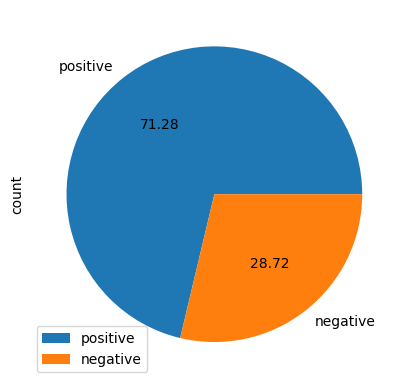

In [106]:
# Visualize sentiment distribution
df['Sentiment_Score_Textblob'].value_counts().plot(kind="pie", autopct="%.2f")
plt.legend(loc="lower left")
plt.show()

## Transformer Model

In [44]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [45]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [46]:

# Function to compute sentiment score using transformer model for each review.
def review_score_compute(text):
    tokens = tokenizer.encode(text, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1


In [47]:
df['Sentiment_Score_Bert'] = df['Review_Final'].apply(lambda x: review_score_compute(x[:512]))

In [56]:
bert_scores_csv = df[['Review_Final', 'Sentiment_Score_Bert']]
bert_scores_csv.columns = ['Review', 'Score']
bert_scores_csv.head()

,Review,Score
0,nice hotel expensive park get good deal stay h...,4
1,ok nothing special charge diamond member hilto...,1
2,nice room not experience hotel monaco seattle ...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay go seahawk game awesome ...,1


In [57]:
#Save BERT scores to CSV file
bert_scores_csv.to_csv('artifacts/bert_scores.csv', index= False)

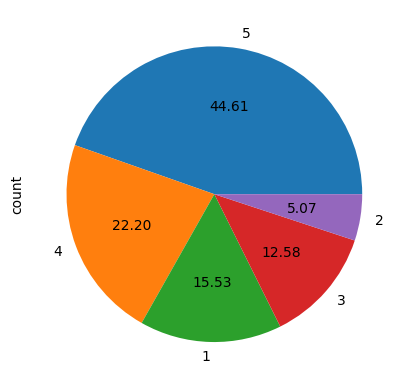

In [48]:
df['Sentiment_Score_Bert'].value_counts().plot(kind="pie", autopct="%.2f")
plt.show()

**Compare Polarity score from Textblob and Sentiment score from Bert**

<Axes: xlabel='Sentiment_Score_Textblob'>

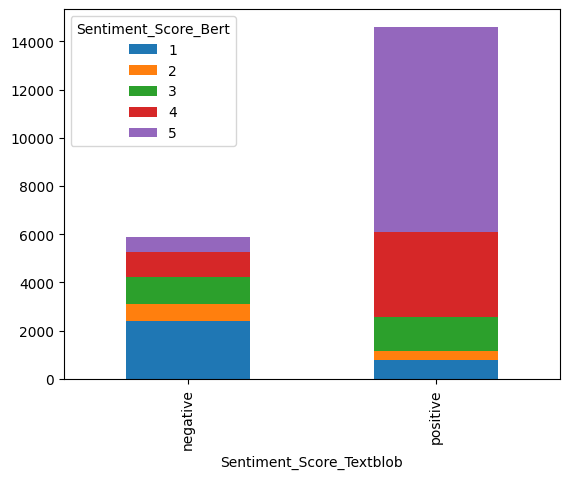

In [114]:
pd.crosstab(df['Sentiment_Score_Textblob'], df['Sentiment_Score_Bert']).plot(kind='bar', stacked = True)

Both models Textblob and Sentiment score from Bert agree well with each other. Major proportions of reviews classified positive by Textblob are given high scores 4 and 5 by the transformer model.

In [159]:
df.head()

,Review,word_count,char_count,average_word_length,stopword_count,stopword_rate,stopwords,Review_Final,char_count_processed,polarity,Sentiment_Score_Textblob,Sentiment_Score_Bert
0,nice hotel expensive parking got good deal sta...,87,593,5.804598,6,0.068966,nice hotel expensive parking got good deal sta...,nice hotel expensive park get good deal stay h...,518,0.246244,positive,4
1,ok nothing special charge diamond member hilto...,250,1689,5.752000,12,0.048000,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,1538,0.185357,negative,1
2,nice rooms not 4* experience hotel monaco seat...,217,1427,5.571429,5,0.023041,nice rooms not experience hotel monaco seattle...,nice room not experience hotel monaco seattle ...,1251,0.336480,positive,3
3,"unique, great stay, wonderful time hotel monac...",89,600,5.730337,3,0.033708,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,539,0.532870,positive,5
4,"great stay great stay, went seahawk game aweso...",191,1281,5.701571,11,0.057592,great stay great stay went seahawk game awesom...,great stay great stay go seahawk game awesome ...,1103,0.382143,positive,1


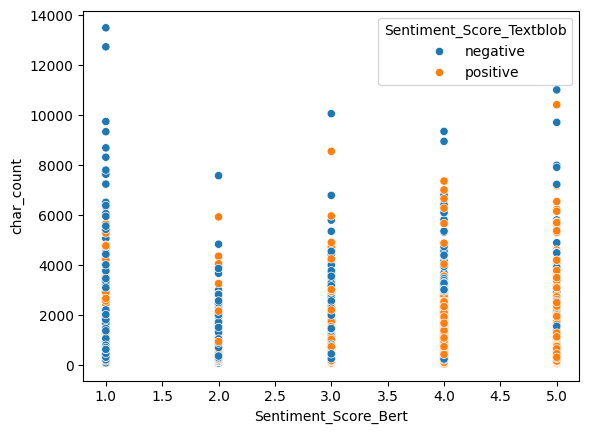

In [164]:
sns.scatterplot(x = df["Sentiment_Score_Bert"], y = df["char_count"], hue=df['Sentiment_Score_Textblob'])

plt.show()